# Test Convolutional Neural Network

In [1]:
tensorflowFolder = "."
STORAGE_NAME = 'model'

# If no GPU support: toggle the next two lines
# GPU_USE = '/cpu:0' 
GPU_USE= '/gpu:0'

In [2]:
import pandas as pd
import numpy as np
import time
import os.path

import matplotlib.pyplot as plt
%matplotlib inline

import math
import scipy.stats

import datetime
from datetime import timedelta

import tensorflow as tf
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import init_ops
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes

In [3]:
tf.__version__

'1.2.1'

In [4]:
class DataSet(object):
    def __init__(self, images, labels, one_hot=False, dtype=dtypes.float32):
        """Construct a DataSet.
        one_hot arg is used only if fake_data is true.    `dtype` can be either
        `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
        `[0, 1]`.
        """
        dtype = dtypes.as_dtype(dtype).base_dtype
        if dtype not in (dtypes.uint8, dtypes.float32):
            raise TypeError('Invalid image dtype %r, expected uint8 or float32' % dtype)
        assert images.shape[0] == labels.shape[0], ('images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
        self._num_examples = images.shape[0]

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        if dtype == dtypes.float32:
            # Convert from [0, 255] -> [0.0, 1.0].'
            images = np.multiply(images, 1.0 / 255.0)
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed
    
    def reset(self):
        self._epochs_completed = 0

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._images[start:end], self._labels[start:end]

def read_data_sets(datapath,
                   one_hot=False,
                   dtype=dtypes.float32,
                   split = (80, 20)):
    print("Loading ...")
    df = pd.read_pickle(datapath)

    # We need to sort the participant in order to ensure that we never use traings data in a test
    ps = np.array(sorted(df.Participant.unique()))
    x1 = math.floor(len(ps) * split[0] / 100.0)
    split_train = ps[:x1]
    x2 = math.floor(len(ps) * split[1] / 100.0)
    split_test = ps[x1:]
    
    print ("Slpit by samples : %.2f / %.2f "% (np.round(len(split_train) / len(ps),2), np.round(len(split_test) / len(ps),2)))
    
    n_input_x = df.MatrixCroppedSameSize.iloc[0].shape[0]
    n_input_y = df.MatrixCroppedSameSize.iloc[0].shape[1]
    n_input_channels = 1
    
    df2 = df[df.Participant.isin(split_train)]
    xList = []
    for x in np.array(df2.MatrixCroppedSameSize):
        xList.append(x.reshape(n_input_x, n_input_y, n_input_channels))
    train_images = np.array(xList)
    train_labels = np.concatenate((np.array(df2.Pitch).reshape(len(df2),1), np.array(df2.Yaw).reshape(len(df2),1)), axis=1)
    
        
    df2 = df[df.Participant.isin(split_test)]
    xList = []
    for x in np.array(df2.MatrixCroppedSameSize):
        xList.append(x.reshape(n_input_x, n_input_y, n_input_channels))
    test_images = np.array(xList)    
    test_labels = np.concatenate((np.array(df2.Pitch).reshape(len(df2),1), np.array(df2.Yaw).reshape(len(df2),1)), axis=1)
    
    seed = np.random.randint(0, 10000000)
    np.random.seed(seed)
    np.random.shuffle(train_images)
    np.random.seed(seed)
    np.random.shuffle(train_labels)
    
    seed = np.random.randint(0, 10000000)
    np.random.seed(seed)
    np.random.shuffle(test_images)
    np.random.seed(seed)
    np.random.shuffle(test_labels)
    
    train = DataSet(train_images, train_labels, dtype=dtype)
    test = DataSet(test_images, test_labels, dtype=dtype)
    
    del df
    del df2
    print("Done!")
    return base.Datasets(train=train, test=test, validation=None)

In [5]:
data = read_data_sets('./data/all_data.pkl')

Loading ...
Slpit by samples : 0.79 / 0.21 
Done!


In [6]:
print("Size of:")
print("- Training-set:\t%i" % len(data.train.labels))
print("- Test-set:\t%i" % len(data.test.labels))

Size of:
- Training-set:	368836
- Test-set:	88432


In [7]:
# Change is line if you want to test a new modle
input_checkpoint = tensorflowFolder + '/'+ STORAGE_NAME + '/papermodel/model-6'

output_node_name = "output_tensor:0"
input_node_name = "input_tensor:0"
train_batch_size = 100

tf.reset_default_graph()
init = tf.global_variables_initializer()

# You may want to ajust the "config.gpu_options"
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth=False
config.gpu_options.per_process_gpu_memory_fraction=0.1
config.gpu_options.allocator_type = 'BFC'

saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=True)
with tf.Session(config=config) as sess:
    sess.run(init)
    saver.restore(sess, input_checkpoint)

    graph = tf.get_default_graph()
        
    _x = graph.get_tensor_by_name(input_node_name)
    
    input_graph_def = graph.as_graph_def()

    op_to_restore = graph.get_tensor_by_name(output_node_name)
            
    epochs = data.test.epochs_completed
    true_y = np.array([]) 
    pred_y = np.array([])
    while True:
        x_batch, y_batch = data.test.next_batch(train_batch_size)

        y_pred_batch = sess.run([op_to_restore], feed_dict= {_x: x_batch})#, _y_true: y_batch} )

        if len(true_y) == 0:
            true_y = y_batch
            pred_y = y_pred_batch[0]
        else:
            true_y = np.concatenate((true_y, y_batch), axis=0)
            pred_y = np.concatenate((pred_y, y_pred_batch[0]), axis=0)

        if epochs != data.test.epochs_completed:    
            break

INFO:tensorflow:Restoring parameters from ./model/papermodel/model-6


In [8]:
diff_true = true_y[:,0] + true_y[:,1]
diff_pred = pred_y[:,0] + pred_y[:,1]
RMSE = np.sqrt(np.mean(np.square(np.subtract(diff_pred, diff_true))))
RMSEPitch = np.sqrt(np.mean(np.square(np.subtract(pred_y[:,0], true_y[:,0]))))
RMSEYaw   = np.sqrt(np.mean(np.square(np.subtract(pred_y[:,1], true_y[:,1]))))

In [9]:
RMSEPitch

12.798557320463349

In [10]:
RMSEYaw

24.19498806275924

In [11]:
RMSE

27.156041031383459

In [12]:
df2 = pd.DataFrame(np.array([true_y[:,0], true_y[:,1], pred_y[:,0], pred_y[:,1]]).T)
df2.columns = ["Pitch", "Yaw", "PitchPred", "YawPred"]

In [13]:
df2["PitchGroup"]  = np.round(df2.Pitch)
df2["PitchError"] = np.abs(df2.Pitch - df2.PitchPred)
dataPitch = df2.groupby("PitchGroup").PitchError.mean()

df2["YawGroup"]  = np.round(df2.Yaw)
df2["YawError"] = np.abs(df2.Yaw - df2.YawPred)
dataYaw = df2.groupby("YawGroup").YawError.mean()

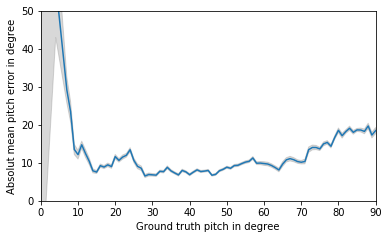

In [14]:
fig, ax = plt.subplots(figsize=(6,3.5))

plt.plot(dataPitch.index, dataPitch.values)
plt.xlim(0,90)
plt.ylim(0,50)
plt.xlabel("Ground truth pitch in degree")
plt.ylabel("Absolut mean pitch error in degree")

lUpper = list()
lLower = list()
for j in sorted(df2['PitchGroup'].unique()):
    a = df2[df2['PitchGroup'] == j]
    a = a['PitchError']
    a = a.tolist()
    low, up = scipy.stats.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=scipy.stats.sem(a))
    lLower.append(low)
    lUpper.append(up)

ax.fill_between(sorted(df2['PitchGroup'].unique()), lUpper, lLower, color='gray', alpha=0.3)

plt.show()

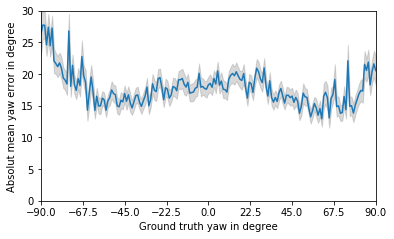

In [15]:
fig, ax = plt.subplots(figsize=(6,3.5))

plt.plot(dataYaw.index, dataYaw.values)
plt.xlim(-90,90)
plt.ylim(0,30)
plt.xlabel("Ground truth yaw in degree")
plt.ylabel("Absolut mean yaw error in degree")

plt.xticks(np.arange(-90,91,45/2))
lUpper = list()
lLower = list()
for j in sorted(df2['YawGroup'].unique()):
    a = df2[df2['YawGroup'] == j]
    a = a['YawError']
    a = a.tolist()
    low, up = scipy.stats.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=scipy.stats.sem(a))
    lLower.append(low)
    lUpper.append(up)

ax.fill_between(sorted(df2['YawGroup'].unique()), lUpper, lLower, color='gray', alpha=0.3)

plt.show()